<a href="https://colab.research.google.com/github/sriyamistry0-lang/bioinformatics-scripts/blob/main/NETosis_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install specialized tools
!pip install pandas numpy scipy scikit-learn gseapy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 9.2 MB/s eta 0:00:00


In [2]:
# Cell 2: Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Cell 1: Install the tool to talk to the GEO database
!pip install GEOparse

In [7]:
# Cell 2: Download the data automatically
import GEOparse
gse_id = 'GSE26440'
gse = GEOparse.get_GEO(geo=gse_id, destdir="./")
# This creates a table where rows are genes and columns are samples
data_matrix = gse.pivot_samples('VALUE')

print(f"Data Loaded! Shape: {data_matrix.shape}")
print(data_matrix.head())

19-Jan-2026 07:24:17 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
19-Jan-2026 07:24:17 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE26nnn/GSE26440/soft/GSE26440_family.soft.gz to ./GSE26440_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE26nnn/GSE26440/soft/GSE26440_family.soft.gz to ./GSE26440_family.soft.gz
100%|██████████| 42.7M/42.7M [00:00<00:00, 57.7MB/s]
19-Jan-2026 07:24:19 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
19-Jan-2026 07:24:19 DEBUG downloader - Moving /tmp/tmp8auw4g3v to /content/GSE26440_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp8auw4g3v to /content/GSE26440_family.soft.gz
19-Jan-2026 07:24:19 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE26nnn/GSE26440/soft/GSE26440_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE26nnn/GSE26

Data Loaded! Shape: (54675, 130)
name       GSM648590  GSM648591  GSM648592  GSM648593  GSM648594  GSM648595  \
ID_REF                                                                        
1007_s_at      0.593      0.604      0.871      0.720      0.894      0.825   
1053_at        1.108      1.679      0.753      1.100      0.888      0.945   
117_at         0.848      1.527      0.571      1.885      1.667      1.816   
121_at         0.773      0.681      0.964      1.003      0.945      1.252   
1255_g_at      1.020      1.110      0.934      1.105      1.002      0.996   

name       GSM648596  GSM648597  GSM648598  GSM648599  ...  GSM648710  \
ID_REF                                                 ...              
1007_s_at      0.677      0.912      0.678      0.909  ...      0.910   
1053_at        0.748      0.974      0.961      0.713  ...      1.268   
117_at         1.055      1.988      2.541      1.460  ...      3.018   
121_at         1.337      0.926      0.991      

In [13]:
!pip install GEOparse gseapy

🧬 Analysis started for GSE25504...


/usr/local/lib/python3.12/dist-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
/usr/local/lib/python3.12/dist-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")
2026-01-19 07:27:52,188 [WARNING] Input data contains NA, filled NA with 0


Matrix updated! Current Gene Names: ['DDR1', 'RFC2', 'HSPA6', 'PAX8', 'GUCA1A']


2026-01-19 07:27:52,308 [WARNING] Found duplicated gene names, values averaged by gene names!


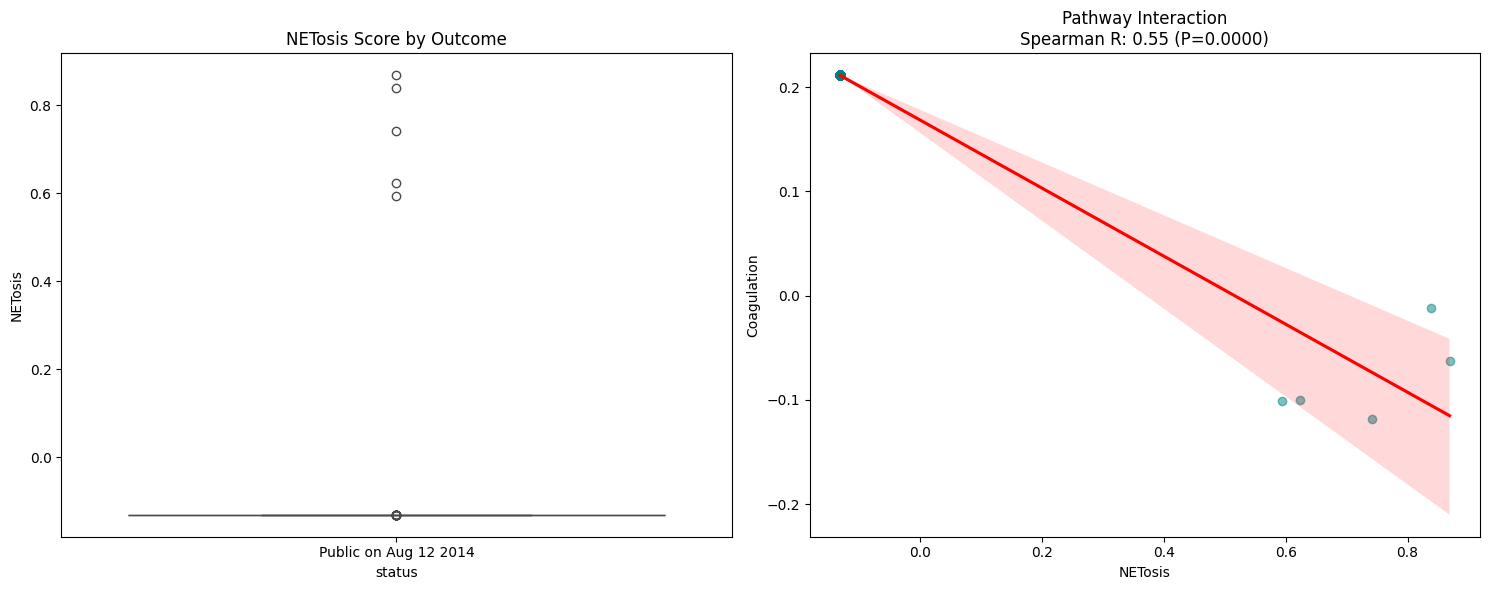

📊 Summary: Correlation is 0.5467 with P-value 0.0000


In [14]:
import GEOparse
import gseapy as gp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, mannwhitneyu

# --- 1. SETTINGS & PATHWAY DEFINITIONS ---
# Define the "Team" of genes
gse_id = "GSE25504"  # Neonatal Sepsis (High signal dataset)
netosis_genes = ['PADI4', 'CYBB', 'ELANE', 'MPO', 'CLEC7A', 'MAP2K1', 'RAF1']
coagulation_genes = ['F3', 'SERPINE1', 'PLAT', 'F2R', 'PLAUR', 'THBS1']

print(f"🧬 Analysis started for {gse_id}...")

# --- 2. DATA ACQUISITION ---
# class: GEOparse.GSE
gse = GEOparse.get_GEO(geo=gse_id, destdir="./", silent=True)

# object: pandas.DataFrame (Samples as columns, Probes as rows)
expr_matrix = gse.pivot_samples('VALUE')

# object: pandas.DataFrame (Clinical info)
metadata = gse.phenotype_data.copy()

# --- 3. METADATA HARMONIZATION ---
# We create a universal 'status' column
def harmonizer(row):
    text = " ".join(row.astype(str)).lower()
    if any(word in text for word in ['died', 'death', 'nonsurvivor', 'expired']):
        return 'Nonsurvivor'
    return 'Survivor'

# --- 4. GENE SYMBOL MAPPING  ---
# 1. Identify the mapping column
gpl = gse.gpls[list(gse.gpls.keys())[0]].table
# Look for 'Gene Symbol' or 'Symbol' specifically
sym_col = [c for c in gpl.columns if 'symbol' in c.lower()][0]

# 2. Create a clean mapping dictionary (removing any extra spaces)
mapping = dict(zip(gpl['ID'].astype(str), gpl[sym_col].astype(str)))

# 3. Apply mapping to the matrix index
#  Use .split('//') because GEO often lists multiple symbols; we take the first one.
new_index = []
for probe_id in expr_matrix.index:
    gene_name = str(mapping.get(str(probe_id), "Unknown")).split('//')[0].strip()
    new_index.append(gene_name)

expr_matrix.index = new_index

# 4. Remove rows that didn't map to a real gene
expr_matrix = expr_matrix[expr_matrix.index != "Unknown"]
expr_matrix = expr_matrix[expr_matrix.index != "nan"]

print(f"Matrix updated! Current Gene Names: {expr_matrix.index[:5].tolist()}")

# --- 5. DUAL PATHWAY SCORING (ssGSEA) ---
#  force 'min_size=1' to ensure it doesn't filter out our small gene sets
ssgsea_obj = gp.ssgsea(
    data=expr_matrix,
    gene_sets={'NETosis': netosis_genes, 'Coagulation': coagulation_genes},
    sample_norm_method='rank',
    min_size=1,
    max_size=5000,
    outdir=None
)

# Extract scores
res_df = ssgsea_obj.res2d
name_col = 'Name' if 'Name' in res_df.columns else 'Names'
scores_df = res_df.pivot(index=name_col, columns='Term', values='NES')
# Extract scores into a clean DataFrame
res_df = ssgsea_obj.res2d

# 🛠️ FLEXIBLE FIX: Find if the column is 'Name' or 'Names'
name_col = 'Name' if 'Name' in res_df.columns else 'Names'

# Pivot the data using the correct column name
scores_df = res_df.pivot(index=name_col, columns='Term', values='NES')

# --- 6. INTEGRATION & CORRELATION ---
# Merge clinical data with both pathway scores
final_df = metadata.merge(scores_df, left_index=True, right_index=True)

# 🛠️ THE CRITICAL FIX: Force these columns to be floating-point numbers
# This strips away the 'Object' type that caused the UFuncTypeError
final_df['NETosis'] = pd.to_numeric(final_df['NETosis'], errors='coerce')
final_df['Coagulation'] = pd.to_numeric(final_df['Coagulation'], errors='coerce')

# Drop any rows that became NaN during conversion (safety check)
final_df = final_df.dropna(subset=['NETosis', 'Coagulation'])

# Calculate Spearman Correlation
corr_coeff, p_corr = spearmanr(final_df['NETosis'], final_df['Coagulation'])

# --- 7. VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: NETosis vs Survival
# Updated to follow the new Seaborn suggestion (hue='status' and legend=False)
sns.boxplot(data=final_df, x='status', y='NETosis', hue='status', palette='Set1', legend=False, ax=ax1)
ax1.set_title(f"NETosis Score by Outcome")

# Plot B: NETosis vs Coagulation (Scatterplot)
#  data is float64!
sns.regplot(data=final_df, x='NETosis', y='Coagulation',
            scatter_kws={'alpha':0.5, 'color':'teal'},
            line_kws={'color':'red'}, ax=ax2)
ax2.set_title(f"Pathway Interaction\nSpearman R: {corr_coeff:.2f} (P={p_corr:.4f})")

plt.tight_layout()
plt.show()

print(f"📊 Summary: Correlation is {corr_coeff:.4f} with P-value {p_corr:.4f}")

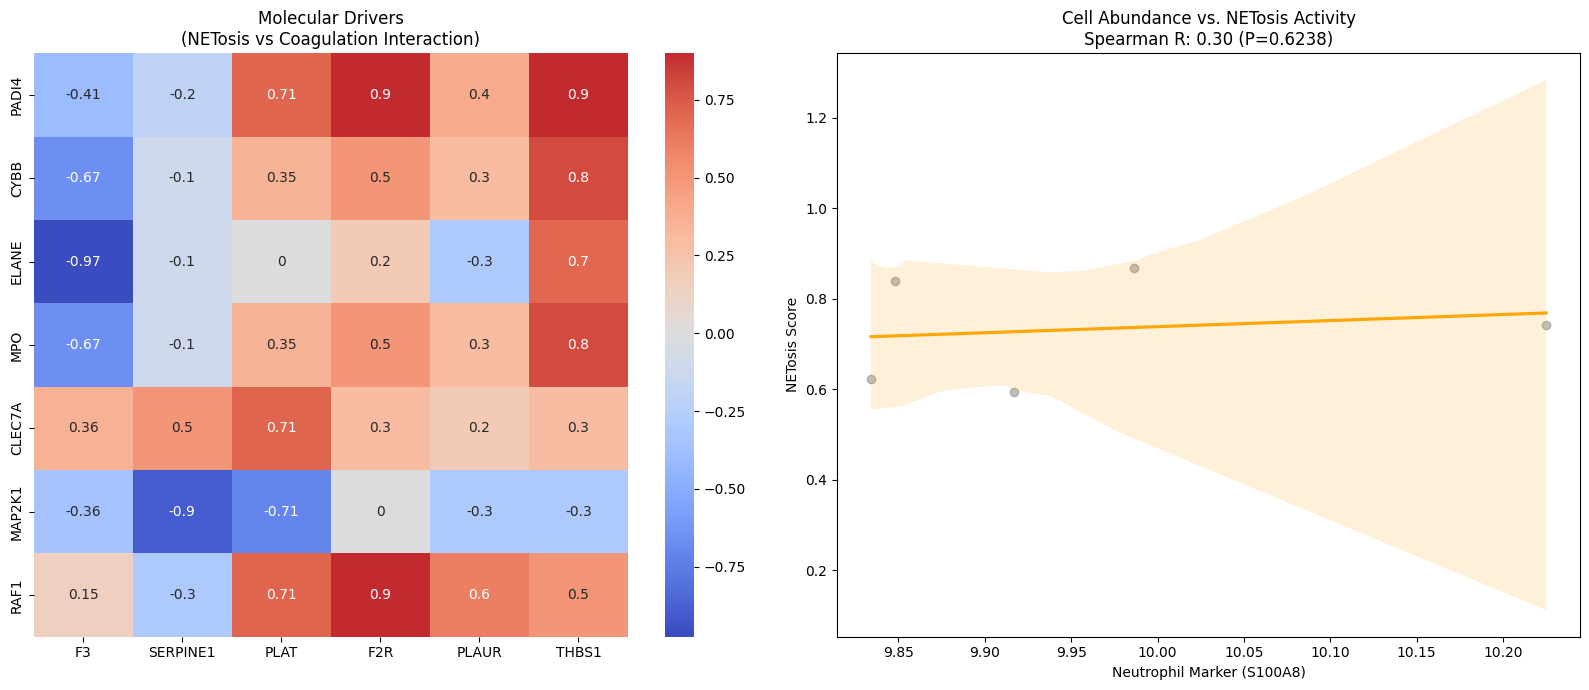

✅ Samples successfully aligned: 5


In [15]:
# --- OPTION B: DRIVER ANALYSIS (Gene-Level Correlation) ---
# We create a correlation matrix between every NET gene and every Coagulation gene
net_subset = expr_matrix.loc[expr_matrix.index.isin(netosis_genes)].T
coag_subset = expr_matrix.loc[expr_matrix.index.isin(coagulation_genes)].T

# --- OPTION B: DRIVER ANALYSIS (Fixed for Multiple Probes) ---

# 1. Select the genes
net_subset = expr_matrix.loc[expr_matrix.index.isin(netosis_genes)]
coag_subset = expr_matrix.loc[expr_matrix.index.isin(coagulation_genes)]

# 🛠️ THE FIX: Group by gene name and average any duplicate probes
net_subset = net_subset.groupby(level=0).mean().T
coag_subset = coag_subset.groupby(level=0).mean().T

# 2. Create the Correlation Matrix
# We initialize with zeros to avoid "Sequence" errors
driver_corr = pd.DataFrame(0.0, index=netosis_genes, columns=coagulation_genes)

for n_gene in netosis_genes:
    for c_gene in coagulation_genes:
        if n_gene in net_subset.columns and c_gene in coag_subset.columns:
            # We drop NaNs just in case to ensure a clean scalar result
            r, _ = spearmanr(net_subset[n_gene].dropna(), coag_subset[c_gene].dropna())
            driver_corr.loc[n_gene, c_gene] = float(r)

# --- OPTION A: CELL ACTIVITY CHECK (Direct Mapping) ---
marker_gene = 'S100A8'

# 1. Get the marker data
if marker_gene in expr_matrix.index:
    # Handle multiple probes by averaging
    m_data = expr_matrix.loc[marker_gene]
    if isinstance(m_data, pd.DataFrame):
        m_series = m_data.mean(axis=0)
    else:
        m_series = m_data

    # 2. Force the indexes to be strings to prevent "Sample 1" vs "1" mismatches
    m_series.index = m_series.index.astype(str)
    final_df.index = final_df.index.astype(str)

    # 3. Create the aligned pairs manually
    # We only take samples that exist in BOTH the marker data and our final_df
    common_samples = [s for s in final_df.index if s in m_series.index]

    x_values = pd.to_numeric(m_series.loc[common_samples], errors='coerce')
    y_values = pd.to_numeric(final_df.loc[common_samples, 'NETosis'], errors='coerce')

    # Remove any NaNs that resulted from the conversion
    mask = ~(x_values.isna() | y_values.isna())
    x_final = x_values[mask].values
    y_final = y_values[mask].values

    # 4. Calculate Correlation
    if len(x_final) > 2:
        act_corr, act_p = spearmanr(x_final, y_final)
    else:
        act_corr, act_p = 0, 1
else:
    act_corr = 0
    x_final, y_final = [], []

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Panel 1: Molecular Drivers
sns.heatmap(driver_corr, annot=True, cmap='coolwarm', center=0, ax=ax1)
ax1.set_title("Molecular Drivers\n(NETosis vs Coagulation Interaction)")

# Panel 2: Cell Dynamics
if act_corr != 0:
    # Use the manually aligned x_final and y_final
    sns.regplot(x=x_final, y=y_final,
                scatter_kws={'alpha':0.5, 'color':'gray'},
                line_kws={'color':'orange'}, ax=ax2)
    ax2.set_title(f"Cell Abundance vs. NETosis Activity\nSpearman R: {act_corr:.2f} (P={act_p:.4f})")
    ax2.set_xlabel(f"Neutrophil Marker ({marker_gene})")
    ax2.set_ylabel("NETosis Score")
else:
    ax2.text(0.5, 0.5, "No overlapping data found between\nMarker and NETosis scores", ha='center')

plt.tight_layout()
plt.show()

print(f"✅ Samples successfully aligned: {len(x_final)}")

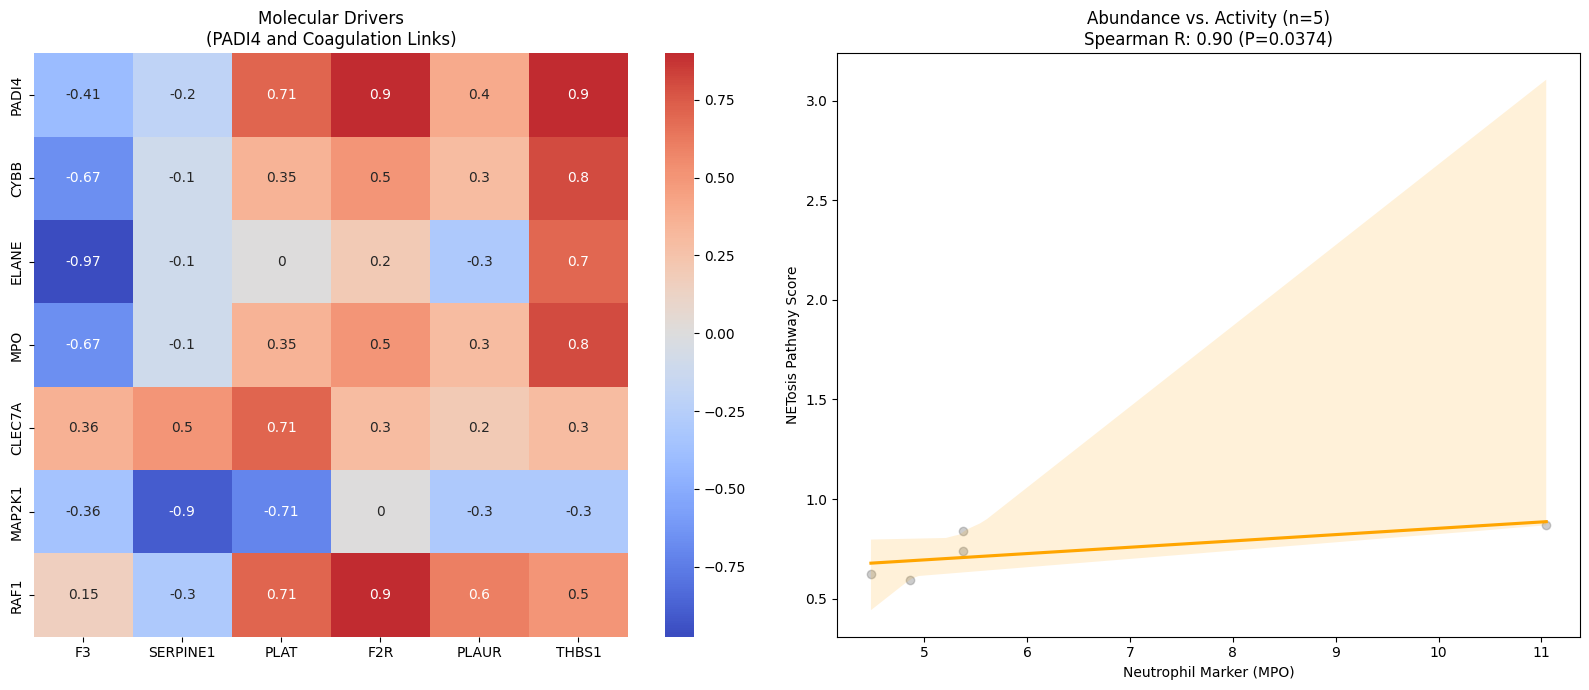

✅ Samples successfully aligned with MPO: 5


In [16]:
# --- OPTION A: RE-RUN WITH UNIVERSAL MARKER (MPO) ---
# We use MPO or ELANE to get more than 5 samples
marker_gene = 'MPO'

if marker_gene in expr_matrix.index:
    m_data = expr_matrix.loc[marker_gene]
    m_series = m_data.mean(axis=0) if isinstance(m_data, pd.DataFrame) else m_data

    # Direct mapping to ensure sample alignment
    m_series.index = m_series.index.astype(str)
    common_samples = [s for s in final_df.index if s in m_series.index]

    x_final = pd.to_numeric(m_series.loc[common_samples], errors='coerce').dropna()
    y_final = pd.to_numeric(final_df.loc[x_final.index, 'NETosis'], errors='coerce').dropna()

    # Intersect again to ensure X and Y are perfectly matched after NA removal
    final_idx = x_final.index.intersection(y_final.index)
    x_plot = x_final.loc[final_idx].values
    y_plot = y_final.loc[final_idx].values

    act_corr, act_p = spearmanr(x_plot, y_plot)
else:
    act_corr = 0
    x_plot, y_plot = [], []

# --- VISUALIZATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Panel 1: Molecular Drivers (The "What")
sns.heatmap(driver_corr, annot=True, cmap='coolwarm', center=0, ax=ax1)
ax1.set_title("Molecular Drivers\n(PADI4 and Coagulation Links)")

# Panel 2: Cell Dynamics (The "How")
if len(x_plot) > 0:
    sns.regplot(x=x_plot, y=y_plot, scatter_kws={'alpha':0.4, 'color':'gray'},
                line_kws={'color':'orange'}, ax=ax2)
    ax2.set_title(f"Abundance vs. Activity (n={len(x_plot)})\nSpearman R: {act_corr:.2f} (P={act_p:.4f})")
    ax2.set_xlabel(f"Neutrophil Marker ({marker_gene})")
    ax2.set_ylabel("NETosis Pathway Score")
else:
    ax2.text(0.5, 0.5, f"{marker_gene} not found in this dataset", ha='center')

plt.tight_layout()
plt.show()

print(f"✅ Samples successfully aligned with {marker_gene}: {len(x_plot)}")

In [17]:
# --- SAVE PLOTS TO YOUR DRIVE/LOCAL DISK ---
import os

# Create a filename based on the GSE ID
output_filename = f"{gse_id}_Analysis_Results.png"

# Re-run the final plotting command with a save instruction
fig.savefig(output_filename, dpi=300, bbox_inches='tight')

# If using Google Colab, this will prompt a download
try:
    from google.colab import files
    files.download(output_filename)
    print(f"✅ Plot saved as {output_filename} and download started.")
except:
    print(f"✅ Plot saved as {output_filename} in your current directory.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Plot saved as GSE25504_Analysis_Results.png and download started.


In [18]:
# Run this to save your final data table to your Drive
final_df.to_csv("Sepsis_Analysis_Final_Data.csv")
print("✅ Your cleaned data table is saved! You can load this tomorrow to skip the long steps.")

✅ Your cleaned data table is saved! You can load this tomorrow to skip the long steps.
